<a href="https://colab.research.google.com/github/TheBugMaker/zindi_sanral/blob/master/UberCT_2_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 2: Stepping up our game 2

This notebook is designed to accompany this blog post https://datasciencecastnet.home.blog/2019/10/21/zindi-uberct-part-2-stepping-up/.

It will take you through adding some extra features, creating a deep learning model with fastai and making a submission.

# Load data

Upload the train.csv and road_segments.zip files from Zindi, as well as the weather.csv file described in the blog post (or available for download here ADD LINK)

In [0]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [0]:
from sklearn.metrics import log_loss, f1_score

In [0]:
data = pd.read_csv('train.csv', 
                   parse_dates = ['Occurrence Local Date Time'])
data.head()

,EventId,Occurrence Local Date Time,Reporting Agency,Cause,Subcause,Status,longitude,latitude,road_segment_id,isAccident,isPedestrian
0,60558,2016-01-01 00:53:31,Cam,Stationary Vehicle,Vehicle On Shoulder,Closed,18.540896,-33.888275,S0B3CGQ,False,False
1,60559,2016-01-01 00:54:46,CAMERA,Accident,With A Fixed Object,Closed,18.930756,-34.140857,RYJYAPI,True,False
2,60560,2016-01-01 02:26:16,Law Enforcement,Accident,Multi Vehicle,Closed,18.553358,-33.959154,U3KP57C,True,False
3,60561,2016-01-01 02:56:26,CAMERA,Stationary Vehicle,Vehicle On Shoulder,Closed,18.677556,-33.895258,RY0TRQ8,False,False
4,60562,2016-01-01 03:40:48,CAMERA,Accident,Multi Vehicle,Closed,18.837132,-34.087051,8LOVJZ3,True,False


In [0]:
data.tail()

,EventId,Occurrence Local Date Time,Reporting Agency,Cause,Subcause,Status,longitude,latitude,road_segment_id,isAccident,isPedestrian
53840,152136,2018-12-31 21:14:00,Camera,Stationary Vehicle,Shoulder Lane,Closed,18.601735,-33.989120,CZBWW0Z,False,False
53841,152139,2018-12-31 21:33:00,Camera,Stationary Vehicle,Shoulder Lane,Closed,18.576595,-33.970978,7AKUBY4,False,False
53842,152142,2018-12-31 22:01:00,SAPS,Police and Military,Hijacking,Closed,18.658576,-33.949194,YQCBO2Y,False,False
53843,152143,2018-12-31 22:12:00,Camera,Stationary Vehicle,Shoulder Lane,Closed,18.625080,-33.888283,Z2OSI9E,False,False
53844,152149,2018-12-31 23:45:00,SAPS,Stationary Vehicle,Shoulder Lane,Closed,18.652948,-33.976858,GFX7S4B,False,False


I'm splitting it up into train and test sets for local testing. When ready, re-do the steps training with all data and make predictions for the dates covered by Zindi's sample submission.

In [0]:
# Train on 2017
train = data.loc[data['Occurrence Local Date Time'] < '2018-04-01']

# Test locally on the last part of 2018
test = data.loc[data['Occurrence Local Date Time'] < '2019-01-01']
test = test.loc[test['Occurrence Local Date Time'] >= '2018-09-01']

In [0]:
# Create a dataframe with a column for each segment_id (sid)
# Each row represents an hour.

sids = data['road_segment_id'].unique()

## <<<<<<<<<<<<<<<<<<<< Added dates, excluding missing data
p1 = pd.date_range('2016-01-01',
                    '2016-07-01',
                    freq="1h")
p2 = pd.date_range('2016-09-01',
                    '2018-04-01',
                    freq="1h")
dts = p1.union(p2)

tr = pd.DataFrame({'datetime':dts})

for sid in sids:
    tr[str(sid)] = 0
    events = train.loc[train['road_segment_id'] == sid]
    dts = events['Occurrence Local Date Time'].dt.round('H')
    dates = dts.astype(str).unique()
    tr.loc[tr['datetime'].isin(dates), sid] = 1
tr.head()

,datetime,S0B3CGQ,RYJYAPI,U3KP57C,RY0TRQ8,8LOVJZ3,X4UA382,0QR8FDW,DZABHQW,EKZN1VM,H9XYX9Q,03RHJ3G,FTX7LB8,Q03FQ74,5AC6YRF,1RWEBRU,DCB3LQM,HN83F3L,SPPGKO2,C1ERJ22,AJRKP0C,UUZT4OE,WAC029P,JT4HGZ2,8Z5P9T1,UAXX1ZE,74A6FL0,2M1UBKJ,E5D3KEB,NQSL7FX,S200A1J,ETFFDX5,R6JUSZT,EDXK0HP,N5NO82G,5DHNI4S,VUYACXV,VMCY8BI,927BHUF,3MW0MN9,...,J8FAZRB,P66KAPS,CJJI1XY,K3N8ADC,SG89YSS,XYFQJ1Q,QTT8QNT,LC8FONX,WJXP54Z,GVQD9D6,64QSPWU,LRCHHQJ,Q2HCM1O,F055OA5,SY568EU,QBSA1OR,8YJIRQ2,KVOVDD8,H983665,7T2W8WU,4NSOFJG,4UAL23D,956JU5F,B8NRA4K,PH8DIYU,F47NAGJ,1NG8I9K,ZP9STNM,D3349RH,E4L0I98,YVR8GT6,ZAVM3PJ,DS4NLQE,HR19LL7,1451FOG,2ON8NSO,NFUEAN5,4T821GV,J6A19TW,43RCYZH
0,2016-01-01 00:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2016-01-01 01:00:00,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2016-01-01 02:00:00,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2016-01-01 03:00:00,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2016-01-01 04:00:00,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
# Reshape this as in sample submission
# I add some extra columns that may be useful
train = pd.DataFrame({
    'datetime x segment_id':np.concatenate([[str(x) + " x " + str(c) 
                                             for c in sids] 
                                            for x in tr['datetime']]),
    'datetime':np.concatenate([[str(x) for c in sids] for x in tr['datetime']]),
    'segment_id':np.concatenate([[str(c) for c in sids] for x in tr['datetime']]),
    'y':tr[sids].values.flatten()
})
train.head()

,datetime x segment_id,datetime,segment_id,y
0,2016-01-01 00:00:00 x S0B3CGQ,2016-01-01 00:00:00,S0B3CGQ,0
1,2016-01-01 00:00:00 x RYJYAPI,2016-01-01 00:00:00,RYJYAPI,0
2,2016-01-01 00:00:00 x U3KP57C,2016-01-01 00:00:00,U3KP57C,0
3,2016-01-01 00:00:00 x RY0TRQ8,2016-01-01 00:00:00,RY0TRQ8,0
4,2016-01-01 00:00:00 x 8LOVJZ3,2016-01-01 00:00:00,8LOVJZ3,0


In [0]:
# Same for test 
dts = pd.date_range('2018-09-01','2018-12-31',
                    freq="1h")
tr = pd.DataFrame({'datetime':dts})

for sid in sids:
    tr[str(sid)] = 0
    events = test.loc[test['road_segment_id'] == sid]
    dts = events['Occurrence Local Date Time'].dt.round('H')
    dates = dts.astype(str).unique()
    tr.loc[tr['datetime'].isin(dates), sid] = 1
    
test = pd.DataFrame({
    'datetime x segment_id':np.concatenate([[str(x) + " x " + str(c) 
                                             for c in sids] 
                                            for x in tr['datetime']]),
    'datetime':np.concatenate([[str(x) for c in sids] for x in tr['datetime']]),
    'segment_id':np.concatenate([[str(c) for c in sids] for x in tr['datetime']]),
    'y':tr[sids].values.flatten()
})
test.head()

,datetime x segment_id,datetime,segment_id,y
0,2018-09-01 00:00:00 x S0B3CGQ,2018-09-01 00:00:00,S0B3CGQ,0
1,2018-09-01 00:00:00 x RYJYAPI,2018-09-01 00:00:00,RYJYAPI,0
2,2018-09-01 00:00:00 x U3KP57C,2018-09-01 00:00:00,U3KP57C,0
3,2018-09-01 00:00:00 x RY0TRQ8,2018-09-01 00:00:00,RY0TRQ8,0
4,2018-09-01 00:00:00 x 8LOVJZ3,2018-09-01 00:00:00,8LOVJZ3,0


# Adding info from road_segments.shp

In [0]:
!pip install geopandas

     |████████████████████████████████| 921kB 2.8MB/s 
     |████████████████████████████████| 11.9MB 35.7MB/s 
     |████████████████████████████████| 10.1MB 23.2MB/s 
  Created wheel for munch: filename=munch-2.3.2-py2.py3-none-any.whl size=6614 sha256=05f9683c1afca5bef8bda9fa83a755df3ba16489c37761ee848f5190a1230f77
  Stored in directory: /root/.cache/pip/wheels/db/bf/bc/06a3e1bfe0ab27d2e720ceb3cff3159398d92644c0cec2c125
Successfully built munch


In [0]:
!unzip road_segments.zip

Archive:  road_segments.zip
   creating: road_segments/
  inflating: road_segments/road_segments.shp  
  inflating: road_segments/road_segments.qpj  
  inflating: road_segments/road_segments.shx  
  inflating: road_segments/road_segments.dbf  
  inflating: road_segments/road_segments.cpg  
  inflating: road_segments/road_segments.prj  


,ROADNO,CLASS,REGION,WIDTH,LANES,SURFTYPE,PAVETYPE,CONDITION,length_1,segment_id,geometry
0,R300,Primary,Western Cape,20.2,2,Paved,FLEX,Good,471.207,D1U6OOF,"LINESTRING (18.65262 -33.97724, 18.65264 -33.9..."
1,R300,Primary,Western Cape,20.2,2,Paved,FLEX,Good,471.207,NG4X2MD,"LINESTRING (18.65347 -33.97309, 18.65347 -33.9..."
2,R300,Primary,Western Cape,20.2,2,Paved,FLEX,Good,471.207,792705Z,"LINESTRING (18.65431 -33.96894, 18.65432 -33.9..."
3,R300,Primary,Western Cape,20.2,2,Paved,FLEX,Good,471.207,IK67XHB,"LINESTRING (18.65515 -33.96480, 18.65517 -33.9..."
4,R300,Primary,Western Cape,20.2,2,Paved,FLEX,Good,471.207,OWCF2MH,"LINESTRING (18.65600 -33.96065, 18.65602 -33.9..."


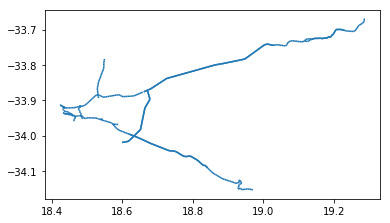

In [0]:
import geopandas as gpd
road_segments = gpd.read_file('road_segments/road_segments.shp')
road_segments.geometry.plot()
road_segments.head()

# Getting locations of each segment

In [0]:
locations = data.groupby('road_segment_id').mean()[['longitude', 'latitude']]
locations.head(2)

,longitude,latitude
road_segment_id,,
03RHJ3G,18.460052,-33.943181
044ZYVD,18.555037,-33.890148


# Adding weather

In [0]:
w = pd.read_csv('weather.csv', sep=";", skiprows=6, usecols=range(14),
               parse_dates=['Local time in Cape Town (airport)'])
w.head()

,Local time in Cape Town (airport),T,P0,P,U,DD,Ff,ff10,WW,W'W',c,VV,Td,Unnamed: 13
0,2019-04-04 23:00:00,15.0,762.0,765.8,77.0,Wind blowing from the south-southeast,6.0,NaN,NaN,NaN,"Scattered clouds (40-50%) 720 m, broken clouds...",10.0 and more,11.0,NaN
1,2019-04-04 22:00:00,16.0,761.2,765.0,77.0,Wind blowing from the south-southeast,6.0,NaN,NaN,NaN,"Scattered clouds (40-50%) 570 m, broken clouds...",10.0 and more,12.0,NaN
2,2019-04-04 21:59:00,16.0,761.2,765.0,77.0,Wind blowing from the south-southeast,6.0,NaN,NaN,NaN,"Scattered clouds (40-50%) 570 m, broken clouds...",10.0 and more,12.0,NaN
3,2019-04-04 21:01:00,15.0,761.2,765.0,94.0,Wind blowing from the south-southeast,6.0,NaN,NaN,NaN,"Scattered clouds (40-50%) 150 m, broken clouds...",10.0 and more,14.0,NaN
4,2019-04-04 21:00:00,15.0,761.2,765.0,94.0,Wind blowing from the south-southeast,6.0,NaN,NaN,NaN,"Scattered clouds (40-50%) 150 m, broken clouds...",10.0 and more,14.0,NaN


In [0]:
# Add weather
w['dt'] = w['Local time in Cape Town (airport)'].dt.round('H')
w_cols = ['dt', 'T', 'P0', 'P', 'U', 'Ff']

# Merge in the new data and add date vars etc

In [0]:
# Pre-process the train
train['datetime'] = pd.to_datetime(train['datetime'])
train['month'] = train['datetime'].dt.month
train['day'] = train['datetime'].dt.weekday_name
train['min'] = train['datetime'].dt.hour*60+train['datetime'].dt.minute
train = pd.merge(train, road_segments, on='segment_id', how='left') # Segment info
train = pd.merge(train, locations, left_on='segment_id', right_on='road_segment_id', how='left') # Segment locations
train = pd.merge(train, w[w_cols], left_on='datetime', right_on='dt', how='left') # Weather

# Pre-process the test to match train
test['datetime'] = pd.to_datetime(test['datetime'])
test['month'] = test['datetime'].dt.month
test['day'] = test['datetime'].dt.weekday_name
test['min'] = test['datetime'].dt.hour*60+test['datetime'].dt.minute
test = pd.merge(test, road_segments, on='segment_id', how='left')
test = pd.merge(test, locations, left_on='segment_id', right_on='road_segment_id', how='left')
test = pd.merge(test, w[w_cols], left_on='datetime', right_on='dt', how='left')

train.head()

,datetime x segment_id,datetime,segment_id,y,month,day,min,ROADNO,CLASS,REGION,WIDTH,LANES,SURFTYPE,PAVETYPE,CONDITION,length_1,geometry,longitude,latitude,dt,T,P0,P,U,Ff
0,2016-01-01 00:00:00 x S0B3CGQ,2016-01-01,S0B3CGQ,0,1,Friday,0,N1,Primary,Western Cape,0.0,0,Paved,Unknown,Unknown,521.765,"LINESTRING (18.54354 -33.89011, 18.54268 -33.8...",18.541422,-33.888613,2016-01-01,22.0,756.0,759.7,83.0,5.0
1,2016-01-01 00:00:00 x RYJYAPI,2016-01-01,RYJYAPI,0,1,Friday,0,N2,Primary,Western Cape,12.8,2,Paved,FLEX,Very Good,521.945,"LINESTRING (18.93214 -34.13857, 18.93208 -34.1...",18.931088,-34.139930,2016-01-01,22.0,756.0,759.7,83.0,5.0
2,2016-01-01 00:00:00 x U3KP57C,2016-01-01,U3KP57C,0,1,Friday,0,N2,Primary,Western Cape,0.0,0,Paved,Unknown,Unknown,452.679,"LINESTRING (18.55332 -33.95934, 18.54963 -33.9...",18.550771,-33.958279,2016-01-01,22.0,756.0,759.7,83.0,5.0
3,2016-01-01 00:00:00 x RY0TRQ8,2016-01-01,RY0TRQ8,0,1,Friday,0,R300,Primary,Western Cape,20.2,2,Paved,FLEX,Fair,493.974,"LINESTRING (18.67690 -33.89936, 18.67691 -33.8...",18.677475,-33.896611,2016-01-01,22.0,756.0,759.7,83.0,5.0
4,2016-01-01 00:00:00 x 8LOVJZ3,2016-01-01,8LOVJZ3,0,1,Friday,0,N2,Primary,Western Cape,20.2,2,Paved,FLEX,Very Good,569.263,"LINESTRING (18.83297 -34.08474, 18.83303 -34.0...",18.836121,-34.086109,2016-01-01,22.0,756.0,759.7,83.0,5.0


In [0]:
train.shape

(10744000, 25)

In [0]:
test.shape

(1759840, 25)

# Create an equivalent dataset for submission

In [0]:
# Make the dataframe - dates based on sample submission file
dts = pd.date_range('2019-01-01 01:00:00',
                    '2019-03-31 23:00:00',
                    freq="1h")
tr = pd.DataFrame({'datetime':dts})

for sid in sids:
    tr[str(sid)] = 0
    
ss = pd.DataFrame({
    'datetime x segment_id':np.concatenate([[str(x) + " x " + str(c)  
                                            for x in tr['datetime']for c in sids]]),
    'datetime':np.concatenate([[str(x) for x in tr['datetime']for c in sids]]),
    'segment_id':np.concatenate([[str(c) for x in tr['datetime']for c in sids]])
})
ss.head()

,datetime x segment_id,datetime,segment_id
0,2019-01-01 01:00:00 x S0B3CGQ,2019-01-01 01:00:00,S0B3CGQ
1,2019-01-01 01:00:00 x RYJYAPI,2019-01-01 01:00:00,RYJYAPI
2,2019-01-01 01:00:00 x U3KP57C,2019-01-01 01:00:00,U3KP57C
3,2019-01-01 01:00:00 x RY0TRQ8,2019-01-01 01:00:00,RY0TRQ8
4,2019-01-01 01:00:00 x 8LOVJZ3,2019-01-01 01:00:00,8LOVJZ3


In [0]:
# Add the extra features
ss['datetime'] = pd.to_datetime(ss['datetime'])
ss['day'] = ss['datetime'].dt.weekday_name
ss['month'] = ss['datetime'].dt.month
ss['min'] = ss['datetime'].dt.hour*60+ss['datetime'].dt.minute
ss = pd.merge(ss, road_segments, on='segment_id', how='left')
ss = pd.merge(ss, locations, left_on='segment_id', right_on='road_segment_id', how='left')
ss = pd.merge(ss, w[w_cols], left_on='datetime', right_on='dt', how='left')
ss['prediction'] = 0
ss.head()

,datetime x segment_id,datetime,segment_id,day,month,min,ROADNO_x,CLASS_x,REGION_x,WIDTH_x,LANES_x,SURFTYPE_x,PAVETYPE_x,CONDITION_x,length_1_x,geometry_x,longitude_x,latitude_x,dt_x,T_x,P0_x,P_x,U_x,Ff_x,prediction,ROADNO_y,CLASS_y,REGION_y,WIDTH_y,LANES_y,SURFTYPE_y,PAVETYPE_y,CONDITION_y,length_1_y,geometry_y,longitude_y,latitude_y,dt_y,T_y,P0_y,P_y,U_y,Ff_y
0,2019-01-01 01:00:00 x S0B3CGQ,2019-01-01 01:00:00,S0B3CGQ,Tuesday,1,60,N1,Primary,Western Cape,0.0,0,Paved,Unknown,Unknown,521.765,"LINESTRING (18.54354 -33.89011, 18.54268 -33.8...",18.541422,-33.888613,2019-01-01 01:00:00,19.0,756.8,760.5,88.0,5.0,0,N1,Primary,Western Cape,0.0,0,Paved,Unknown,Unknown,521.765,"LINESTRING (18.54354 -33.89011, 18.54268 -33.8...",18.541422,-33.888613,2019-01-01 01:00:00,19.0,756.8,760.5,88.0,5.0
1,2019-01-01 01:00:00 x RYJYAPI,2019-01-01 01:00:00,RYJYAPI,Tuesday,1,60,N2,Primary,Western Cape,12.8,2,Paved,FLEX,Very Good,521.945,"LINESTRING (18.93214 -34.13857, 18.93208 -34.1...",18.931088,-34.139930,2019-01-01 01:00:00,19.0,756.8,760.5,88.0,5.0,0,N2,Primary,Western Cape,12.8,2,Paved,FLEX,Very Good,521.945,"LINESTRING (18.93214 -34.13857, 18.93208 -34.1...",18.931088,-34.139930,2019-01-01 01:00:00,19.0,756.8,760.5,88.0,5.0
2,2019-01-01 01:00:00 x U3KP57C,2019-01-01 01:00:00,U3KP57C,Tuesday,1,60,N2,Primary,Western Cape,0.0,0,Paved,Unknown,Unknown,452.679,"LINESTRING (18.55332 -33.95934, 18.54963 -33.9...",18.550771,-33.958279,2019-01-01 01:00:00,19.0,756.8,760.5,88.0,5.0,0,N2,Primary,Western Cape,0.0,0,Paved,Unknown,Unknown,452.679,"LINESTRING (18.55332 -33.95934, 18.54963 -33.9...",18.550771,-33.958279,2019-01-01 01:00:00,19.0,756.8,760.5,88.0,5.0
3,2019-01-01 01:00:00 x RY0TRQ8,2019-01-01 01:00:00,RY0TRQ8,Tuesday,1,60,R300,Primary,Western Cape,20.2,2,Paved,FLEX,Fair,493.974,"LINESTRING (18.67690 -33.89936, 18.67691 -33.8...",18.677475,-33.896611,2019-01-01 01:00:00,19.0,756.8,760.5,88.0,5.0,0,R300,Primary,Western Cape,20.2,2,Paved,FLEX,Fair,493.974,"LINESTRING (18.67690 -33.89936, 18.67691 -33.8...",18.677475,-33.896611,2019-01-01 01:00:00,19.0,756.8,760.5,88.0,5.0
4,2019-01-01 01:00:00 x 8LOVJZ3,2019-01-01 01:00:00,8LOVJZ3,Tuesday,1,60,N2,Primary,Western Cape,20.2,2,Paved,FLEX,Very Good,569.263,"LINESTRING (18.83297 -34.08474, 18.83303 -34.0...",18.836121,-34.086109,2019-01-01 01:00:00,19.0,756.8,760.5,88.0,5.0,0,N2,Primary,Western Cape,20.2,2,Paved,FLEX,Very Good,569.263,"LINESTRING (18.83297 -34.08474, 18.83303 -34.0...",18.836121,-34.086109,2019-01-01 01:00:00,19.0,756.8,760.5,88.0,5.0


In [2]:
ss.shape

NameError: ignored

# Listing the columns we've created and will use for modelling

In [0]:
x_cols = ['day', 'segment_id', 'min', 'longitude', 'latitude', 'ROADNO', 'length_1',  'LANES', 'CONDITION', 'month', 'T', 'P0', 'P', 'U', 'Ff']
cat_cols = ['day', 'month', 'segment_id', 'ROADNO',  'LANES', 'CONDITION']

# Training XGBOOST

In [1]:
!pip install xgboost

# Tuning threshold to maximise F1 score:

In [0]:
test['p'] = predictions[:,1]
for t in [0.01, 0.03, 0.035, 0.04, 0.045, 0.05, 0.1, 0.3]:
  test['pt'] = (test['p']>t).astype(int)
  print('Threshold: ', t, 'F1:', f1_score(test['y'], test['pt']))

Threshold:  0.01 F1: 0.06258443510071494
Threshold:  0.03 F1: 0.08219036815509952
Threshold:  0.035 F1: 0.08226900378754515
Threshold:  0.04 F1: 0.0808614520282246
Threshold:  0.045 F1: 0.08091782851498688
Threshold:  0.05 F1: 0.08031522468142187
Threshold:  0.1 F1: 0.06238721319927816
Threshold:  0.3 F1: 0.02692212403997027


Refining more

In [0]:
for t in [0.01, 0.025, 0.027, 0.029, 0.031, 0.033, 0.035, 0.037]:
  test['pt'] = (test['p']>t).astype(int)
  print(t, f1_score(test['y'], test['pt']))

0.01 0.06258443510071494
0.025 0.0803704175693471
0.027 0.08150484761330427
0.029 0.08147240491135062
0.031 0.08248680476354668
0.033 0.08166008569268252
0.035 0.08226900378754515
0.037 0.08255101726738281


# Tuning, submission

So you can see we're getting an F1 score aroud 0.082 on our test set. For some reason I tend to score higher on Zindi! To turn this into a submission, you can use the submission dataset (ss) as the test set for the learner, and then threshold the predicted probabilities based on the top value found above and use that as you submission. Before you do that, I sugest you play around with training for longer, adding different features, tweaking things further..... go crazy :) If you have questions, feel free to get hold of me or, better, post them in the discussions on Zindi. Good luck.